In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import shutil
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

#Importing libraries needed for the modeling and training
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, Callback , ModelCheckpoint
from tensorflow.keras.metrics import Accuracy,binary_crossentropy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pickle
# Load preprocessed datasets from pickle file
with open('/content/drive/MyDrive/preprocessed_data.pkl', 'rb') as f:
    training_images, training_labels, val_images, val_labels, test_images, test_labels = pickle.load(f)


In [4]:
# ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range=0.2)

In [21]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dropout, BatchNormalization, Dense
from keras.optimizers import Adam
from keras.applications import ResNet50

def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    return model

resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet, lr=1e-4)
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23597953 (90.02 MB)
Trainable params: 23

In [22]:
#Compiling the model
model.compile(optimizer='adam',loss='binary_crossentropy' ,metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/.keras",save_best_only=True,)

In [23]:
#Fitted the VGG16 model on the training and and validation dataset using the image augmentor for 70 epochs
history = model.fit(datagen.flow(training_images, training_labels, batch_size = 32),
                                     validation_data=datagen.flow(val_images, val_labels),
                                     epochs=70,
                                     callbacks=[early_stop,checkpoint],
                                     verbose = 1)

Epoch 1/70
159/159 [==============================] - 355s 2s/step - loss: 0.5284 - accuracy: 0.7979 - val_loss: 5.0795 - val_accuracy: 0.7014
Epoch 2/70
159/159 [==============================] - 332s 2s/step - loss: 0.4018 - accuracy: 0.8336 - val_loss: 0.8597 - val_accuracy: 0.7014
Epoch 3/70
159/159 [==============================] - 331s 2s/step - loss: 0.3638 - accuracy: 0.8542 - val_loss: 0.6526 - val_accuracy: 0.7014
Epoch 4/70
159/159 [==============================] - 335s 2s/step - loss: 0.3241 - accuracy: 0.8680 - val_loss: 0.6479 - val_accuracy: 0.7014
Epoch 5/70
159/159 [==============================] - 335s 2s/step - loss: 0.2973 - accuracy: 0.8801 - val_loss: 0.6135 - val_accuracy: 0.7014
Epoch 6/70
159/159 [==============================] - 333s 2s/step - loss: 0.2979 - accuracy: 0.8799 - val_loss: 0.5953 - val_accuracy: 0.7014
Epoch 7/70
159/159 [==============================] - 331s 2s/step - loss: 0.2794 - accuracy: 0.8880 - val_loss: 0.5373 - val_accuracy: 0.7449

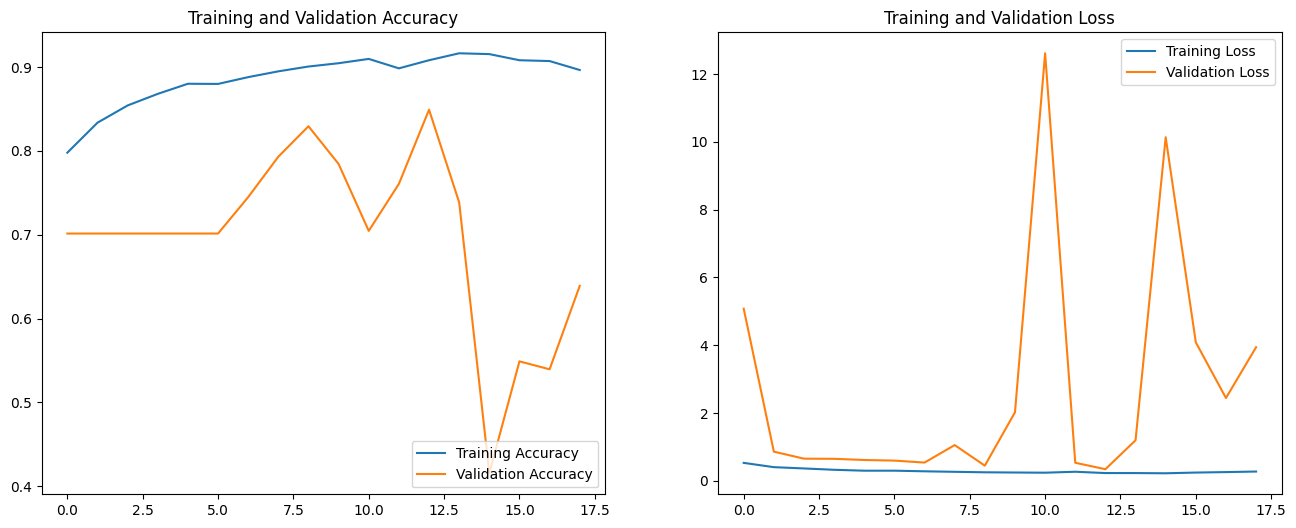

In [24]:
#Plotting the model results

#Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

#No of epochs it trained
epochs_range = history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
resnet_y_pred = model.predict(test_images)

50/50 [==============================] - 25s 504ms/step


In [32]:
print(resnet_y_pred)

[[8.3083695e-01]
 [7.2985239e-35]
 [9.8860914e-01]
 ...
 [9.7714746e-01]
 [1.7531110e-26]
 [9.1224706e-01]]


In [33]:
#Round up model prediction to 0 and 1 and convert result to an array
rounded = [float(np.round(x)) for x in resnet_y_pred]
rounded_resnet = np.asarray(rounded).astype(int)
print(rounded_resnet)

[1 0 1 ... 1 0 1]


<ipython-input-33-27918ab74bbe>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rounded = [float(np.round(x)) for x in resnet_y_pred]


[[ 83 399]
 [161 939]]


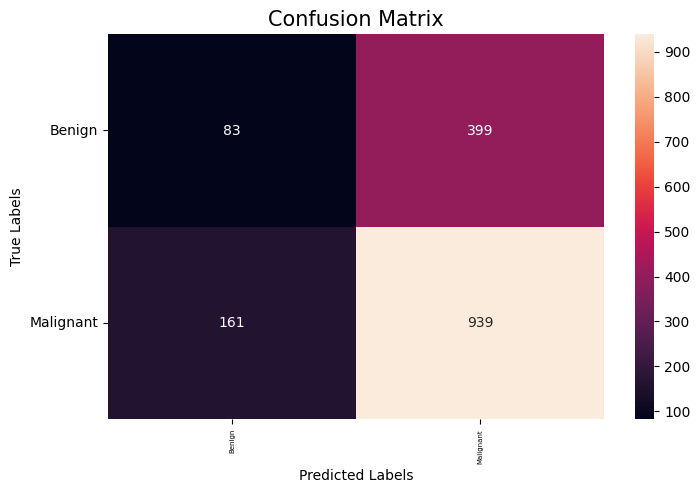

In [34]:
#Confusion matrix
cm = confusion_matrix(test_labels, rounded_resnet)
print(cm)

import seaborn as sns

#Setting the labels
labels = ['Benign', 'Malignant']

#Plot the Confusion matrix graph
fig= plt.figure(figsize=(8, 5))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g')
ax.set_xlabel('Predicted Labels', fontsize=10)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(labels, fontsize = 5)
ax.xaxis.tick_bottom()

ax.set_ylabel('True Labels', fontsize=10)
ax.yaxis.set_ticklabels(labels, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=15)

plt.savefig('ConMat24.png')
plt.show()

In [35]:
#Classification report
print(classification_report(test_labels, rounded_resnet))

              precision    recall  f1-score   support

           0       0.34      0.17      0.23       482
           1       0.70      0.85      0.77      1100

    accuracy                           0.65      1582
   macro avg       0.52      0.51      0.50      1582
weighted avg       0.59      0.65      0.61      1582



In [54]:
#Accuracy
accuracy = accuracy_score(test_labels, rounded_resnet)
print('Accuracy: %f' % accuracy)

Accuracy: 0.646018


In [48]:
#Precision
precision = precision_score(test_labels, rounded_resnet)
print('Precision: %f' % precision)

Precision: 0.701794


In [46]:
# Recall
recall = recall_score(test_labels, rounded_resnet, pos_label=1)
print('Recall: %f' % recall)

Recall: 0.853636


In [44]:
#Specificity
specificity = recall_score(test_labels, rounded_resnet, pos_label=0)
print('Specificity: %f' % specificity)

Specificity: 0.172199


In [40]:
Specificity: 0.717842
#F1-score
F1_score = f1_score(test_labels, rounded_resnet)
print('F1_score: %f' % F1_score)

F1_score: 0.770304


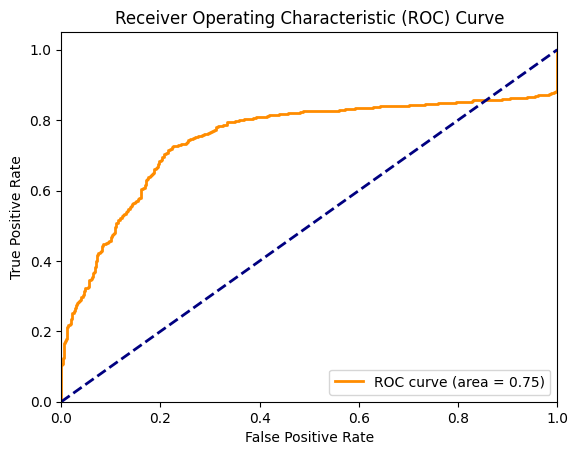

In [41]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, resnet_y_pred)

# Calculate the area under the ROC curve
roc_auc = roc_auc_score(test_labels, resnet_y_pred)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
#Save the model
model.save("/content/drive/MyDrive/Disertatie/ResNet50_Model.h5")

In [55]:
# Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Final accuracy
final_accuracy = acc[-1]
final_val_accuracy = val_acc[-1]

print("Final Training Accuracy:", final_accuracy)
print("Final Validation Accuracy:", final_val_accuracy)


Final Training Accuracy: 0.89646315574646
Final Validation Accuracy: 0.639020562171936
